In [1]:
import random as rnd
import torch
import torchaudio
from torch.utils.data import DataLoader
import classes.ProjectClasses as pcl

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 3060


In [3]:
ANNOTATIONS_FILE_TRAIN = "../train_data/metadata/file_labels.csv"
AUDIO_DIR_TRAIN = "../train_data/files"
ANNOTATIONS_FILE_VAL = "../valid_data/metadata/file_labels.csv"
AUDIO_DIR_VAL = "../valid_data/files"
SAMPLE_RATE = 10000
NUM_SAMPLES = 9600
N_FFT = 400
HOP_LENGTH = 160
N_MELS = 64
LABEL_COL = 2
NUM_CLASSES = 2

tt_utils = pcl.TrainTestUtils(NUM_CLASSES)
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate = SAMPLE_RATE, n_fft = N_FFT, hop_length = HOP_LENGTH, n_mels = N_MELS)
spr_train = pcl.SpikerboxRecordings(ANNOTATIONS_FILE_TRAIN, AUDIO_DIR_TRAIN, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device, LABEL_COL)
spr_valid = pcl.SpikerboxRecordings(ANNOTATIONS_FILE_VAL, AUDIO_DIR_VAL, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device, LABEL_COL)

In [4]:
torch.cuda.empty_cache()
BATCH_SIZE = 128
EPOCHS = 7
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.01

generator = torch.Generator()
generator.manual_seed(569567390)
train_dl = DataLoader(spr_train, batch_size = BATCH_SIZE, shuffle = True, generator = generator)
val_dl = DataLoader(spr_valid, batch_size = BATCH_SIZE, shuffle = False, generator = generator)

VGGish_Grade = pcl.VGGishNetwork(NUM_CLASSES).to(device)
loss_fn = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(VGGish_Grade.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

stats = tt_utils.train(VGGish_Grade, train_dl, val_dl, optimizer, loss_fn, EPOCHS, device)

Epoch [1/7]:
Avg. Train Loss: 1.5207189, Train Accuracy: 89.07%, Scaled Train Accuracy: 89.08%
Avg. Valid Loss: 0.0024748, Valid Accuracy: 99.98%, Scaled Valid Accuracy: 99.98%
Epoch [2/7]:
Avg. Train Loss: 0.0231681, Train Accuracy: 99.31%, Scaled Train Accuracy: 99.31%
Avg. Valid Loss: 0.0014258, Valid Accuracy: 99.98%, Scaled Valid Accuracy: 99.98%
Epoch [3/7]:
Avg. Train Loss: 0.0147114, Train Accuracy: 99.87%, Scaled Train Accuracy: 99.87%
Avg. Valid Loss: 0.0008948, Valid Accuracy: 100.00%, Scaled Valid Accuracy: 100.00%
Epoch [4/7]:
Avg. Train Loss: 0.0158114, Train Accuracy: 99.96%, Scaled Train Accuracy: 99.96%
Avg. Valid Loss: 0.0024652, Valid Accuracy: 99.98%, Scaled Valid Accuracy: 99.98%
Epoch [5/7]:
Avg. Train Loss: 0.0061872, Train Accuracy: 99.97%, Scaled Train Accuracy: 99.97%
Avg. Valid Loss: 0.1281733, Valid Accuracy: 98.47%, Scaled Valid Accuracy: 98.49%
Epoch [6/7]:
Avg. Train Loss: 1.2388973, Train Accuracy: 73.50%, Scaled Train Accuracy: 73.52%
Avg. Valid Loss: 0

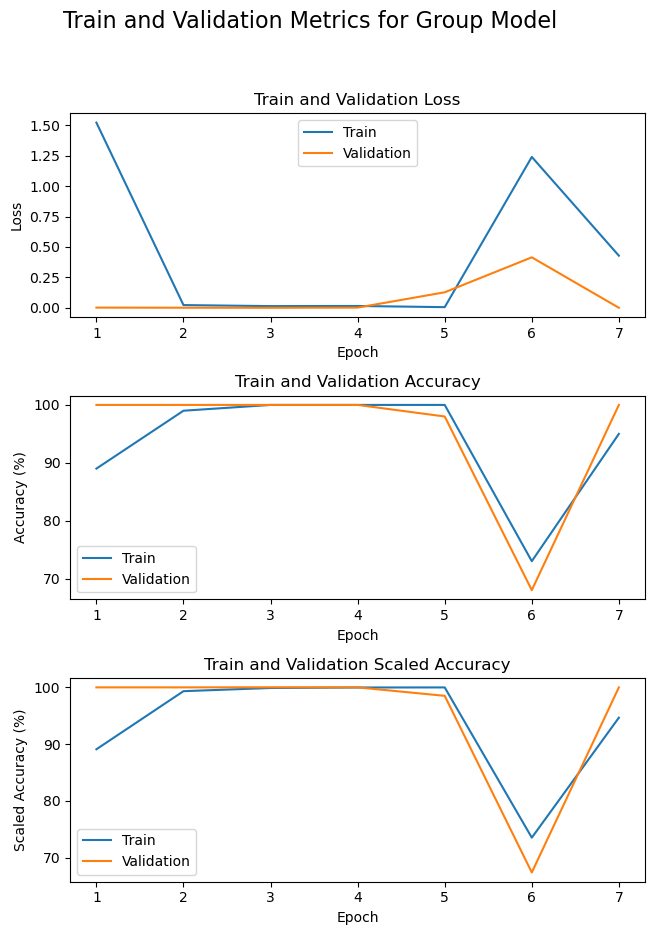

In [5]:
tt_utils.plot_metrics(stats, 'group', '../images')

In [6]:
torch.save(VGGish_Grade.state_dict(), "../trained_models/VGGish_Group.pth")